**24_Vilhelmsen LGR**

In [1]:
import os ; import pathlib as pl ; import pandas as pd ; import numpy as np ;  import matplotlib.pyplot as plt ; from pathlib import Path  
from flopy.plot.styles import styles ; import shapefile as shp ; import matplotlib as mpl ; import flopy ; import flopy.utils.binaryfile as bf 
from modflow_devtools.misc import get_env, timed ; write=get_env("WRITE", True);run=get_env("RUN", True) ; from flopy.utils.lgrutil import Lgr 
sim_ws    = Path("./24ii_LGR")                         ; sim_ws.mkdir(exist_ok=True)     ; sim_name = example_name = "ex-gwf-lgrv"
exe_name  = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe'  ; workspace = figs_path = sim_ws       

In [2]:
length_units = "meters" ; time_units = "seconds"    ; k11_str = "5.e-07, 1.e-06, 5.e-05" ; nouter = 50 ; ninner = 100 ; hclose = 1e-6 ; rclose = 100.0
nper = 1 ;nlay = 25 ;nrow = 183 ;ncol = 147         ; nlaygc = 9 ;nrowcg = 61 ;ncolcg = 49 ;delr = 35 ;delc = 25 ;delv = 5 ;delrgc = 105 
delcgc = 75 ;delvgc = 15 ; top_str = "variable"     ; botm_str = "30 to -90" ; icelltype = 0 ; recharge = 0.0000000011098 ;
parameters = {"ex-gwf-lgrv-gr": {"configuration": "Refined"},"ex-gwf-lgrv-gc": {"configuration": "Coarse"},"ex-gwf-lgrv-lgr": {"configuration": "LGR"}}

In [3]:
path = 'E:\\15_REPOS\\00_BETAMI\\bin\\data_modflow6-examples\\ex-gwf-lgrv'                 ; top = np.loadtxt(os.path.join(path,"top.dat"))
dt = [("k",int),("i",int),("j",int) ,("stage",float),("conductance",float),("rbot",float)] ; rivdat=np.loadtxt(os.path.join(path,"riv.dat"), dtype=dt)
ikzone = np.empty((nlay, nrow, ncol),dtype=float)
for k in range(nlay):                        
    fname = f"ikzone{k + 1}.dat"    ;f_ikzone = os.path.join(path, fname)                   ; ikzone[k, :, :] = np.loadtxt(f_ikzone)
a1 = pd.DataFrame(top)    ; a1.to_csv (sim_ws/ "01_top.csv") ; a1 = pd.DataFrame(rivdat)    ; a1.to_csv (sim_ws/ "02_riv.csv")
a1 = pd.DataFrame(ikzone[24,:,:]) ; a1.to_csv (sim_ws/ "03_ikzone_xy.csv")                  ; print('ikzoneS',ikzone.shape)   # 01 02 03 *.csv

ikzoneS (25, 183, 147)


In [4]:
perlen = [1.0]    ; nstp = [1] ; tsmult = [1.0]             ; tdis_ds = list(zip(perlen, nstp, tsmult))
rivdat["k"] -= 1  ; rivdat["i"] -= 1  ; rivdat["j"] -= 1    ; riv_spd = [[(k, i, j), stage, cond, rbot] for k, i, j, stage, cond, rbot in rivdat]
botm = [30 - k * delv for k in range(nlay)]                 ; botm = np.array(botm)

k11_values = [float(value) for value in k11_str.split(",")] ; k11 = np.zeros((nlay, nrow, ncol), dtype=float)
for i, kval in enumerate(k11_values):                         k11 = np.where(ikzone == i + 1, kval, k11)

xmin = 0 ; xmax = ncol * delr          ; ymin = 0.0 ; ymax = nrow * delc   ; model_domain = [xmin, xmax, ymin, ymax]
child_domain = [xmin + 15 * 3 * delr   , xmin + 41 * 3 * delr              , ymax - 49 * 3 * delc,ymax - 19 * 3 * delc]    # child_domain

In [5]:
def coarsen_shape(icoarsen, nrow, ncol):
    nrowc = int(np.ceil(nrow / icoarsen))   ; ncolc = int(np.ceil(ncol / icoarsen)) ;     return (nrowc, ncolc)
def coarsen_shape(icoarsen, nrow, ncol):
    nrowc = int(np.ceil(nrow / icoarsen))   ; ncolc = int(np.ceil(ncol / icoarsen)) ;    return (nrowc, ncolc)
def create_resampling_labels(a, icoarsen):
    nrow, ncol = a.shape                    ; labels = np.zeros((nrow, ncol), dtype=int) ;     nodec = 0
    for ic in range(0, nrow, icoarsen):
        for jc in range(0, ncol, icoarsen):
            labels[ic : ic + icoarsen, jc : jc + icoarsen] = nodec          ; nodec += 1
    return labels
labels2 = create_resampling_labels; labels2

<function __main__.create_resampling_labels(a, icoarsen)>

In [6]:
def array_resampler(a, icoarsen, method):  
    import scipy.ndimage as ndimage

    assert method in ["mean", "minimum", "maximum", "sum"]
    nrow, ncol = a.shape                               ; nrowc, ncolc = coarsen_shape(icoarsen, nrow, ncol) ;   
    labels = create_resampling_labels(a, icoarsen)     ; idx = np.array(range(nrowc * ncolc))
    if method == "mean":        ar = ndimage.mean    (a, labels=labels, index=idx)
    elif method == "minimum":   ar = ndimage.minimum (a, labels=labels, index=idx)
    elif method == "maximum":   ar = ndimage.maximum (a, labels=labels, index=idx)
    elif method == "sum":       ar = ndimage.sum     (a, labels=labels, index=idx)
    return ar.reshape((nrowc, ncolc))

In [7]:
def riv_resample(icoarsen, nrow, ncol, rivdat, idomain, rowcolspan):
    stage_grid = np.zeros((nrow, ncol), dtype=float)             ; cond_grid = np.zeros((nrow, ncol), dtype=float)
    rbot_grid  = np.zeros((nrow, ncol), dtype=float)             ; count_grid = np.zeros((nrow, ncol), dtype=int)
    for k, i, j, stage, cond, rbot in rivdat:
        stage_grid[i, j] = stage   ; cond_grid[i, j] = cond       ; rbot_grid[i, j] = rbot            ; count_grid[i, j] += 1
    stagec_grid = array_resampler  (stage_grid, icoarsen, "sum")  ; condc_grid      = array_resampler  (cond_grid, icoarsen, "sum")
    rbotc_grid  = array_resampler  (rbot_grid , icoarsen, "sum")  ; countc_grid     = array_resampler  (count_grid, icoarsen, "sum")
    stagec_grid = np.divide(stagec_grid, countc_grid)             ; rbotc_grid      = np.divide(rbotc_grid, countc_grid)
    
    if rowcolspan is not None:
        istart, istop, jstart, jstop = rowcolspan               ; stagec_grid = stagec_grid[istart:istop, jstart:jstop]
        condc_grid = condc_grid[istart:istop, jstart:jstop]     ; rbotc_grid = rbotc_grid[istart:istop, jstart:jstop]
        countc_grid = countc_grid[istart:istop, jstart:jstop]
        
    rows, cols = np.where(condc_grid > 0.0)                     ;  rivdatc = []
    for i, j in zip(rows, cols): 
        k = 0
        if idomain[k, i, j] == 1:             rivdatc.append([(k, i, j), stagec_grid[i, j], condc_grid[i, j], rbotc_grid[i, j]])
    return rivdatc

In [8]:
def build_lgr_model(name):
    icoarsen = 3               ;     ncppl = [1, 3, 3, 3, 3, 3, 3, 3, 3] ;     sim_ws = os.path.join(workspace, name)
    sim = flopy.mf6.MFSimulation  (sim_name=name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis (sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms  (sim,outer_maximum=nouter,outer_dvclose=hclose,inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=f"{rclose} strict")
    sim = build_parent_model (sim, name, icoarsen=icoarsen, ncppl=ncppl)  ;     gwf = sim.get_model("parent")
    sim = build_child_model  (sim, name)                                   ;     gwfc = sim.get_model("child")
    nlayp = len(ncppl)         ; nrowp = gwf.dis.nrow.get_data()  ; ncolp = gwf.dis.ncol.get_data() ; delrp = gwf.dis.delr.array ; 
    delcp = gwf.dis.delc.array ; topp = gwf.dis.top.array         ; botmp = gwf.dis.botm.array      ; idomainp = gwf.dis.idomain.array
    lgr = flopy.utils.lgrutil.Lgr(nlayp ,nrowp ,ncolp ,delrp ,delcp ,topp ,botmp ,idomainp ,ncpp=icoarsen ,ncppl=ncppl)
    topc = gwfc.dis.top.array  ; botmc = gwfc.dis.botm.array ; lgr.top = topc ; lgr.botm = botmc
    exgdata = lgr.get_exchange_data(angldegx=True, cdist=True)
    flopy.mf6.ModflowGwfgwf(sim ,nexg=len(exgdata) ,exgtype="GWF6-GWF6" ,exgmnamea="parent" ,exgmnameb="child",
                            exchangedata=exgdata ,auxiliary=["angldegx", "cdist"])                                           ; return sim

In [9]:
sim = build_lgr_model   # lgr ? 

In [10]:
def build_parent_model(sim, name, icoarsen, ncppl):
    xminp, xmaxp, yminp, ymaxp = model_domain            ; xminc, xmaxc, yminc, ymaxc = child_domain
    delcp = delc * icoarsen                              ; istart = int((ymaxp - ymaxc) / delcp)  ; istop = int((ymaxp - yminc) / delcp)      
    delrp = delr * icoarsen                              ; jstart = int((xminc - xminp) / delrp)  ; jstop = int((xmaxc - xminp) / delrp) 
    nrowp, ncolp = coarsen_shape(icoarsen, nrow, ncol)   ; nlayp = len(ncppl)
    idomain = np.ones((nlayp, nrowp, ncolp), dtype=int)  ; idomain[:, istart:istop, jstart:jstop] = 0
    sim = build_models (name ,icoarsen=icoarsen ,ncppl=ncppl ,idomain=idomain ,sim=sim ,modelname="parent")                       ; return sim
def build_child_model(sim, name):
    icoarsen = 1
    xminp, xmaxp, yminp, ymaxp = model_domain            ; xminc, xmaxc, yminc, ymaxc = child_domain
    delcp = delc * icoarsen                              ; istart = int((ymaxp - ymaxc) / delcp)   ; istop = int((ymaxp - yminc) / delcp)
    delrp = delr * icoarsen                              ; jstart = int((xminc - xminp) / delrp)   ; jstop = int((xmaxc - xminp) / delrp)
    nrowp, ncolp = coarsen_shape(icoarsen, nrow, ncol)
    sim = build_models(name,rowcolspan=[istart, istop, jstart, jstop],sim=sim,modelname="child",xorigin=xminc,yorigin=yminc)  ; return sim

In [11]:
def build_models(name,icoarsen=1,ncppl=None,rowcolspan=None,idomain=None,sim=None,modelname=None,xorigin=None,yorigin=None):
    head_filerecord = f"{modelname}.hds"
    budget_filerecord = f"{modelname}.cbc"
    # _________________________________________________________________________________________________________
    if sim is None:
        sim_ws = os.path.join  (workspace, name)   
        sim = flopy.mf6.MFSimulation (sim_name=name, sim_ws=sim_ws, exe_name="mf6")
        flopy.mf6.ModflowTdis  (sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
        flopy.mf6.ModflowIms   (sim,outer_maximum=nouter,outer_dvclose=hclose,inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=f"{rclose} strict")
    if modelname is None:       modelname = name
    gwf = flopy.mf6.ModflowGwf (sim, modelname = modelname, save_flows=True)
    
    if ncppl is not None:
        nlayc = len(ncppl)          ; layer_index = [ncppl[0] - 1]
        for iln in ncppl[1:]:
            last = layer_index[-1]  ; layer_index.append(iln + last)
    else:
        nlayc = nlay                ; layer_index = list(range(nlayc))
    nrowc, ncolc = coarsen_shape(icoarsen,nrow,ncol) ;delrc=delr*icoarsen ;delcc=delc*icoarsen     ;topc = array_resampler(top, icoarsen, "mean")
    if rowcolspan is not None:
        istart, istop, jstart, jstop = rowcolspan ; nrowc = istop - istart  ; ncolc = jstop - jstart
    else:
        istart = 0  ; istop = nrow  ; jstart = 0  ; jstop = ncol
    if idomain is None: idomain = 1
    topc = topc[istart: istop, jstart: jstop]
    flopy.mf6.ModflowGwfdis (gwf,length_units=length_units,nlay=nlayc,nrow=nrowc,ncol=ncolc,delr=delrc,delc=delcc,
                             top=topc,botm=botm[layer_index],idomain=idomain,xorigin=xorigin,yorigin=yorigin)
    idomain = gwf.dis.idomain.array
    k11c = []
    for k in range(nlayc):
        ilay = layer_index[k]   ; a = array_resampler(k11[ilay], icoarsen, "maximum")  ; k11c.append(a[istart:istop, jstart:jstop])
    flopy.mf6.ModflowGwfnpf (gwf,k33overk=True,icelltype=icelltype,k=k11c,save_specific_discharge=True,k33=1.0)
    strt = nlayc * [topc]
    flopy.mf6.ModflowGwfic  (gwf, strt=strt)

    rivdatc = riv_resample(icoarsen, nrow, ncol, rivdat, idomain, rowcolspan)  ;     riv_spd = {0: rivdatc}
    flopy.mf6.ModflowGwfriv(gwf,stress_period_data=riv_spd,pname="RIV",)
    flopy.mf6.ModflowGwfrcha(gwf, recharge=recharge, pname="RCH")
    flopy.mf6.ModflowGwfoc(gwf,head_filerecord=head_filerecord,budget_filerecord=budget_filerecord,saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")])
    return sim


def write_models(sim, silent=True): sim.write_simulation(silent=silent)
@timed
def run_models(sim, silent=False):
    success, buff = sim.run_simulation(silent=silent, report=True)  ;     assert success, buff

def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]        ;  params = parameters[key].copy()
    if params["configuration"]   == "Refined" :  sim = build_models(key, modelname="parent")
    elif params["configuration"] == "Coarse"  :
        ncppl = [1, 3, 3, 3, 3, 3, 3, 3, 3]   ;  sim = build_models(key, icoarsen=3, ncppl=ncppl, modelname="parent")
    elif params["configuration"] == "LGR":       sim = build_lgr_model(key)
    if write:  write_models (sim, silent=silent)
    if run:    run_models   (sim, silent=silent)
scenario(1) #; scenario(0); scenario(2)

run_models took 592.16 ms


In [12]:
sim_ws3 = Path("./24ii_LGR/ex-gwf-lgrv-lgr")         ; sim3  = flopy.mf6.MFSimulation.load(sim_ws = sim_ws3 ,exe_name=exe_name, verbosity_level=0) 
gwf3 = sim3.get_model("parent")    ; gwfc = None     ; gwfc3 = sim3.get_model("child")  ; idomain_p = gwf3.dis.idomain.array
tpp  = np.ma.masked_where(idomain_p[0] == 0, gwf3.dis.top.array)     ; vmin = tpp.min()               ;   vmax = tpp.max()
tpcc = gwfc3.dis.top.array                                           ; vmin = min(vmin, tpcc.min())   ;   vmax = max(vmax, tpcc.max())
irow, icol = gwf3.modelgrid.intersect(3000.0, 3000.0)                ; hyc = np.log(gwf3.npf.k.array)

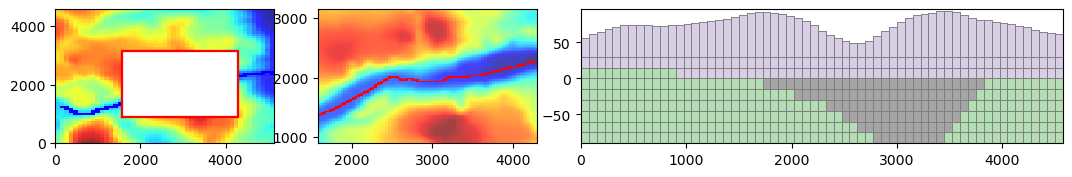

In [13]:
def p_plot(ax):

    pmv=flopy.plot.PlotMapView(model=gwf3, ax=ax1, layer=0)              ; cb = pmv.plot_array(tpp, cmap="jet", alpha=0.25, vmin=vmin, vmax=vmax) 
    pmv.plot_bc(name="RIV", color='blue')  ; xmin, xmax, ymin, ymax = child_domain                          
    ax1.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], color = 'red')

    pmv = flopy.plot.PlotMapView(model=gwfc3, ax=ax2, layer=0)              ; _  = pmv.plot_array(tpcc,cmap="jet",alpha=0.2,masked_values=[1e30])    
    pmv.plot_bc(name="RIV", color='red')  #; cbar=plt.colorbar(_)

    pmv = flopy.plot.PlotCrossSection(model=gwf3, ax=ax3, line={"column": icol})            ; cc = pmv.plot_array(hyc, cmap="Accent", alpha=0.25)
    pmv.plot_grid(linewidth=0.5)
    
plt.figure(figsize=(13,8))
ax1 = plt.subplot2grid((4, 4), (0, 0), colspan=1, rowspan=1)  ; ax2 = plt.subplot2grid((4, 4), (0, 1), colspan=1, rowspan=1)  
ax3 = plt.subplot2grid((4, 4), (0, 2), colspan=2, rowspan=1)  ; p_plot(ax1) ; p_plot(ax2) ; p_plot(ax3)

In [14]:
sim_ws3 = Path("./24ii_LGR/ex-gwf-lgrv-lgr")         ; sim3  = flopy.mf6.MFSimulation.load(sim_ws = sim_ws3 ,exe_name=exe_name, verbosity_level=0) 
gwf31 = sim3.get_model("parent")    ; gwf32 = sim3.get_model("child")
layer=0 ; head31=gwf31.output.head().get_data() ;head31 = np.ma.masked_where(head31 > 1e29, head31) ; vmin=head31[layer].min() ;vmax=head31[layer].max()
layer=0 ; head32=gwf32.output.head().get_data() ;head32 = np.ma.masked_where(head32 > 1e29, head32) ; vmin=head32[layer].min() ;vmax=head32[layer].max()

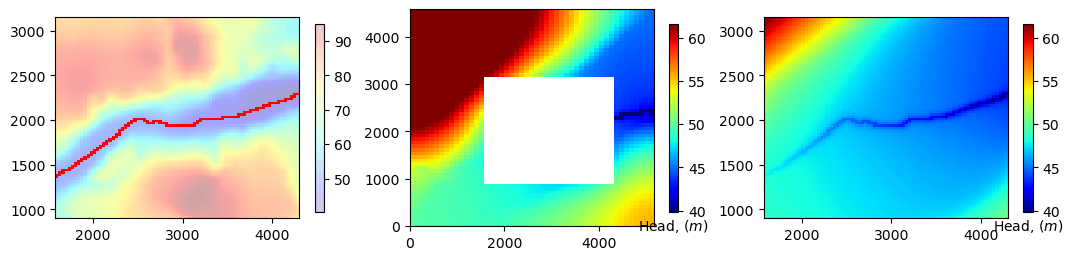

In [16]:
fig = plt.figure(figsize=(11,5))  
ax = fig.add_subplot(1, 3, 1, aspect="equal")  ; fig.tight_layout()
pmv = flopy.plot.PlotMapView(model=gwfc3, ax=ax, layer=0)              ; _  = pmv.plot_array(tpcc,cmap="jet",alpha=0.2,masked_values=[1e30])    
pmv.plot_bc(name="RIV", color='red')  ; cbar=plt.colorbar(_, shrink=0.4)       

ax = fig.add_subplot(1, 3, 2, aspect="equal")  ; fig.tight_layout()
pmv = flopy.plot.PlotMapView(model=gwf31, ax=ax, layer=0)        ; cb = pmv.plot_array(head31, cmap="jet", masked_values=[1e30], vmin=vmin, vmax=vmax)  
cbar = plt.colorbar(cb, shrink=0.4) ; cbar.ax.set_xlabel(r"Head, ($m$)")         

ax = fig.add_subplot(1, 3, 3, aspect="equal")  ; fig.tight_layout()
pmv = flopy.plot.PlotMapView(model=gwf32, ax=ax, layer=0)        ; cb = pmv.plot_array(head32, cmap="jet", masked_values=[1e30], vmin=vmin, vmax=vmax)  
cbar = plt.colorbar(cb, shrink=0.4) ; cbar.ax.set_xlabel(r"Head, ($m$)")       

plt.show()